Online payment fraud detection using various classification techniques

In [42]:
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load only part of the data
# Too many samples
# Sample without replacement
data = pd.read_csv("data/credit_card.csv").sample(n=100_000, random_state=42)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedataraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


In [43]:
data.isnull().sum()

step                0
type                0
amount              0
nameOrig            0
oldbalanceOrg       0
newbalanceOrig      0
nameDest            0
oldbalanceDest      0
newbalanceDest      0
isFraud             0
isFlaggedataraud    0
dtype: int64

In [44]:
type = data["type"].value_counts()

# Extract the transaction's names
transactions = type.index
# Extract the quantity of each transaction
quantity = type.values

# See the distribution of the transactions in a pie chart
figure = px.pie(data, 
             values=quantity, 
             names=transactions, hole = 0.5, 
             title="Distribution of Transaction Type")
figure.show()

Top correlations with isFraud:
isFraud             1.000000
isFlaggedataraud    0.084156
amount              0.077999
step                0.034990
type                0.024051
oldbalanceOrg       0.006952
newbalanceDest     -0.004081
oldbalanceDest     -0.009096
newbalanceOrig     -0.010106
Name: isFraud, dtype: float64


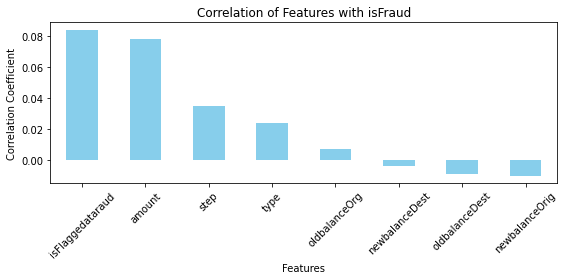

In [ ]:
correlation = data.corr()

# Extract and sort correlations with the target variable
fraud_correlation = correlation["isFraud"].sort_values(ascending=False)

# Display top correlations
print("Top correlations with isFraud:")
print(fraud_correlation)

# Visualize top features correlated with isFraud
plt.figure(figsize=(8, 4))
fraud_correlation.drop("isFraud").plot(kind="bar", color="skyblue")
plt.title("Correlation of Features with isFraud")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# Preprocessing
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})

data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedataraud
3737323,278,3,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,2,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,3,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,4,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,3,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0



Training Decision Tree...
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.57      0.57      0.57        28

    accuracy                           1.00     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       1.00      1.00      1.00     20000

Decision Tree ROC-AUC Score: 0.785

Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.77      0.61      0.68        28

    accuracy                           1.00     20000
   macro avg       0.89      0.80      0.84     20000
weighted avg       1.00      1.00      1.00     20000

Random Forest ROC-AUC Score: 0.927

Training XGBoost...
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.

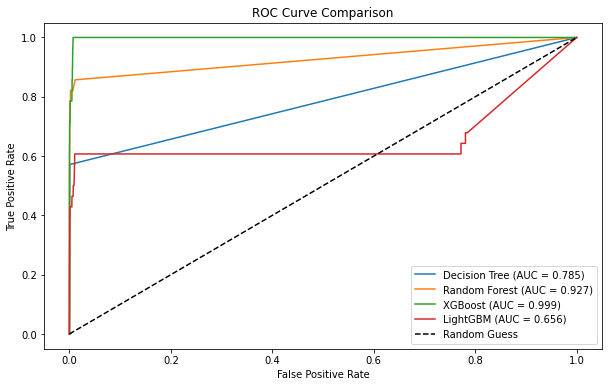


Confusion Matrix for Decision Tree:


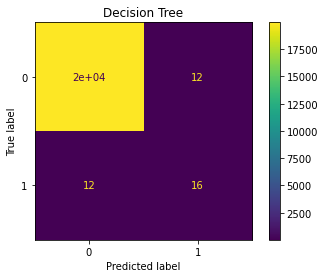


Confusion Matrix for Random Forest:


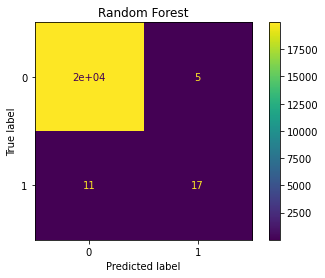


Confusion Matrix for XGBoost:


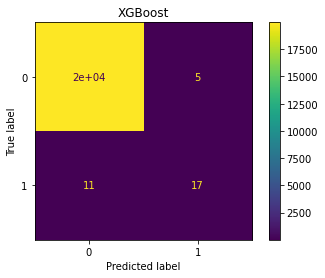


Confusion Matrix for LightGBM:


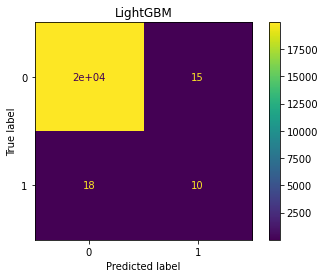

In [47]:
# Split the data in features and label
x = np.array(data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(data[["isFraud"]])

# Split the data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

ytrain = ytrain.ravel()
ytest = ytest.ravel()

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, objective='binary:logistic',eval_metric="logloss", use_label_encoder=False, random_state=42),
    "LightGBM": lgb.LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, objective='binary', random_state=42)
}

# Train and evaluate models
results = {}
roc_curves = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    yproba = model.predict_proba(xtest)[:, 1]
    
    # Metrics
    print(f"{name} Classification Report:")
    print(classification_report(ytest, ypred))
    roc_auc = roc_auc_score(ytest, yproba)
    print(f"{name} ROC-AUC Score: {roc_auc:.3f}")
    
    # Save results for ROC curve
    fpr, tpr, _ = roc_curve(ytest, yproba)
    roc_curves[name] = (fpr, tpr)
    results[name] = {"roc_auc": roc_auc, "confusion_matrix": confusion_matrix(ytest, ypred)}

# Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot Confusion Matrices
for name, metrics in results.items():
    cm = metrics["confusion_matrix"]
    print(f"\nConfusion Matrix for {name}:")
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(name)
    plt.show()


Tuning Decision Tree...
Best Parameters for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.75      0.54      0.63        28

    accuracy                           1.00     20000
   macro avg       0.87      0.77      0.81     20000
weighted avg       1.00      1.00      1.00     20000

Decision Tree ROC-AUC Score: 0.942

Tuning Random Forest...
Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.89      0.61      0.72        28

    accuracy                           1.00     20000
   macro avg       0.95      0.80      0.86     20000
weighted avg       1

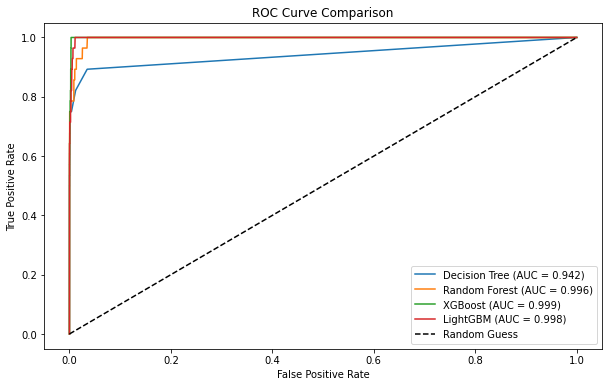


Confusion Matrix for Decision Tree:


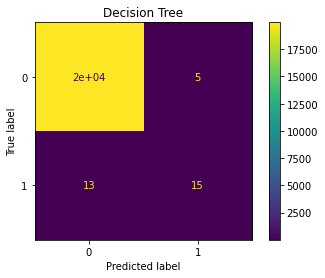


Confusion Matrix for Random Forest:


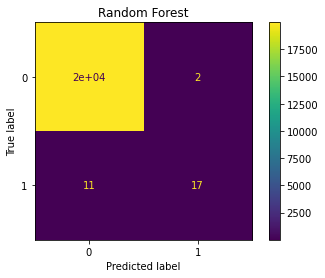


Confusion Matrix for XGBoost:


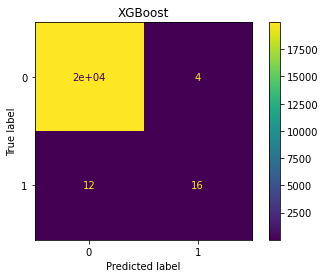


Confusion Matrix for LightGBM:


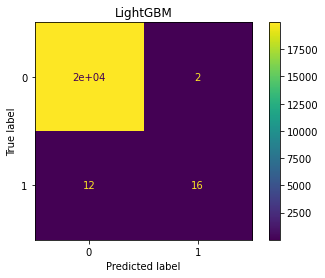

In [49]:
# Models and Hyperparameter Grids
models = {
    "Decision Tree": (DecisionTreeClassifier(random_state=42), {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    "Random Forest": (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    "XGBoost": (xgb.XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False), {
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200]
    }),
    "LightGBM": (lgb.LGBMClassifier(random_state=42), {
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200]
    })
}

# Training and Evaluation
results = {}
roc_curves = {}

for name, (model, param_grid) in models.items():
    print(f"\nTuning {name}...")
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3, scoring='roc_auc', random_state=42)
    random_search.fit(xtrain, ytrain)
    best_model = random_search.best_estimator_
    print(f"Best Parameters for {name}: {random_search.best_params_}")
    
    # Predictions
    ypred = best_model.predict(xtest)
    yproba = best_model.predict_proba(xtest)[:, 1]
    
    # Metrics
    print(f"{name} Classification Report:")
    print(classification_report(ytest, ypred))
    roc_auc = roc_auc_score(ytest, yproba)
    print(f"{name} ROC-AUC Score: {roc_auc:.3f}")
    
    # Save results for ROC curve
    fpr, tpr, _ = roc_curve(ytest, yproba)
    roc_curves[name] = (fpr, tpr)
    results[name] = {"roc_auc": roc_auc, "confusion_matrix": confusion_matrix(ytest, ypred)}

# Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot Confusion Matrices
for name, metrics in results.items():
    cm = metrics["confusion_matrix"]
    print(f"\nConfusion Matrix for {name}:")
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(name)
    plt.show()

We see that the overall winner is XGBoost, followed by LightGBM and Random Forest. The Simple Decision Tree is last because it's too simple to capture the underlying dependecies. XGBoost is on first place because it uses penalty which Random Forest doesn't. LightGBM and XGBoost have a lot of similarities, but LigthGBM is optimized for speed and memory-efficience and won't always give the best results.